<a href="https://colab.research.google.com/github/surucodes/Image_captioning_model_from_Scratch/blob/main/Image_captioning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import string
import numpy as np
import os
from pickle import dump, load
import matplotlib.pyplot as plt
from tensorflow.keras.applications.xception import Xception, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import add, Input, Dense, LSTM, Embedding, Dropout
from tensorflow.keras.models import Model, load_model
from tqdm import tqdm_notebook as tqdm
import time
from PIL import Image
tqdm().pandas()

<ipython-input-1-60b6d277dacc>:17: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  tqdm().pandas()


0it [00:00, ?it/s]

In [2]:
from tensorflow.keras.utils import get_file


In [3]:
#load text file into the memory
def load_doc(file_name):
    file = open(file_name, 'r')
    text = file.read()
    file.close
    return text

In [4]:
'''we convert images into features using the xception model. We give image feature and Caption sequence
as input features and captions are predicted sequence by sequence using lstm etc '''
''' we have the same single image 5 times and 5 different captions for the same image '''
def all_img_captions(filename):
     file = load_doc(filename)
     captions = file.split('\n')
     descriptions = {}
     for caption in captions[:-1]:
        img,caption = caption.split('\t')
        if img[:-2] not in descriptions:
             descriptions[img[:-2]] = [caption]
        else:
            descriptions[img[:-2]].append(caption)
     return descriptions



In [5]:
def cleaning_text(captions):
    table = str.maketrans('', '',string.punctuation)
    for img, caps in captions.items():
        for i,img_caption in enumerate(caps):
            img_caption=img_caption.replace("-","")
            desc = img_caption.split()
            desc = [word.lower() for word in desc]
            desc = [word.translate(table) for word in desc]
            desc = [word for word in desc if len(word) > 1]
            desc = [word for word in desc if(word.isalpha())]

            img_caption = ' '.join(desc)
            captions[img][i] = img_caption
    return captions

In [6]:
def text_vocabulary(descriptions):
    vocab = set()
    for key in descriptions.keys():
        [vocab.update(d.split()) for d in descriptions[key]]
    return vocab

In [7]:
def save_descriptions(descriptions, filename):
    lines = list()
    for key, desc_list in descriptions.items():
        for desc in desc_list:
            lines.append(key + '\t' + desc)
    data = "\n".join(lines)
    file = open(filename,"w")
    file.write(data)
    file.close()

In [8]:
from google.colab import drive
import os
import zipfile

# Mount Google Drive
drive.mount('/content/drive')

# Define paths to the zip files in your Google Drive
drive_flickr_dataset_zip = "/content/drive/MyDrive/Flickr8k_Dataset.zip"
drive_flickr_text_zip = "/content/drive/MyDrive/Flickr8k_text.zip"

# Create directories to extract the files
!mkdir -p /content/Flickr8k_text
!mkdir -p /content/Flicker8k_Dataset

# Extract the zip files
with zipfile.ZipFile(drive_flickr_dataset_zip, 'r') as zip_ref:
    zip_ref.extractall('/content/Flicker8k_Dataset')

with zipfile.ZipFile(drive_flickr_text_zip, 'r') as zip_ref:
    zip_ref.extractall('/content/Flickr8k_text')

# Define the paths as in your original code
dataset_text = "/content/Flickr8k_text"
dataset_images = "/content/Flicker8k_Dataset/Flicker8k_Dataset"
filename = dataset_text + "/Flickr8k.token.txt"

# Verify the files are loaded correctly
print(f"Text dataset path: {dataset_text}")
print(f"Images dataset path: {dataset_images}")
print(f"Token file path: {filename}")

# Check if the token file exists
if os.path.exists(filename):
    # Read a few lines from the token file to verify
    with open(filename, 'r') as f:
        print("First few lines of the token file:")
        for i, line in enumerate(f):
            if i < 5:  # Print first 5 lines
                print(line.strip())
            else:
                break
else:
    print("Token file not found. Check the path and extraction.")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Text dataset path: /content/Flickr8k_text
Images dataset path: /content/Flicker8k_Dataset/Flicker8k_Dataset
Token file path: /content/Flickr8k_text/Flickr8k.token.txt
First few lines of the token file:
1000268201_693b08cb0e.jpg#0	A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg#1	A girl going into a wooden building .
1000268201_693b08cb0e.jpg#2	A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg#3	A little girl climbing the stairs to her playhouse .
1000268201_693b08cb0e.jpg#4	A little girl in a pink dress going into a wooden cabin .


In [9]:

print(dataset_images)  # Should be your image folder path
print(os.listdir(dataset_text)[:5])  # Sample of your images


/content/Flicker8k_Dataset/Flicker8k_Dataset
['__MACOSX', 'Flickr_8k.testImages.txt', 'ExpertAnnotations.txt', 'Flickr8k.lemma.token.txt', 'Flickr8k.token.txt']


In [10]:
descriptions = all_img_captions(filename)
print("Length of descriptions = ",len(descriptions))
# descriptions

Length of descriptions =  8092


In [11]:
clean_descriptions = cleaning_text(descriptions)
vocabulary = text_vocabulary(clean_descriptions)
print("Length of vocabulary =", len(vocabulary))
# vocabulary

Length of vocabulary = 8763


In [12]:
save_descriptions(clean_descriptions,"descriptions.txt")

In [13]:
save_path = "/content/drive/MyDrive/ImageCaptioning/descriptions.txt"
save_descriptions(clean_descriptions, save_path)

In [14]:
print(clean_descriptions)

{'1000268201_693b08cb0e.jpg': ['child in pink dress is climbing up set of stairs in an entry way', 'girl going into wooden building', 'little girl climbing into wooden playhouse', 'little girl climbing the stairs to her playhouse', 'little girl in pink dress going into wooden cabin'], '1001773457_577c3a7d70.jpg': ['black dog and spotted dog are fighting', 'black dog and tricolored dog playing with each other on the road', 'black dog and white dog with brown spots are staring at each other in the street', 'two dogs of different breeds looking at each other on the road', 'two dogs on pavement moving toward each other'], '1002674143_1b742ab4b8.jpg': ['little girl covered in paint sits in front of painted rainbow with her hands in bowl', 'little girl is sitting in front of large painted rainbow', 'small girl in the grass plays with fingerpaints in front of white canvas with rainbow on it', 'there is girl with pigtails sitting in front of rainbow painting', 'young girl with pigtails paintin

In [15]:
def download_with_retry(url,filename,max_retries = 3):
    for attempt in range(max_retries):
        try:
            return get_file(filename,url)
        except Exception as e:
            if attempt == max_retries - 1:
                raise e
            print(f"Download attempt failed")
            time.sleep(3)

In [16]:
weights_url = "https://storage.googleapis.com/tensorflow/keras-applications/xception/xception_weights_tf_dim_ordering_tf_kernels_notop.h5"
weights_path = download_with_retry(weights_url, 'xception_weights.h5')

In [17]:
model = Xception(include_top=False, pooling= "avg",weights=weights_path)

In [18]:
'''
os.path.splitext(img) splits the filename into two parts:
The name without the extension
The extension (including the dot)
Example:
img = "dog.JPG"
os.path.splitext(img)  # returns ('dog', '.JPG')
[1] takes the second element, i.e., the extension: ".JPG" and .lower() makes it lowercase: ".jpg"
This helps in checking file types case-insensitively. '''

'''Let’s say your image shape is:
(299, 299, 3)  # One image of size 299x299 with 3 color channels
But deep learning models (like Xception) expect batches of images, even if it's just 1 image.
So np.expand_dims(image, axis=0) adds a new dimension:
(1, 299, 299, 3)  # batch size of 1
Think of it like putting your single image inside a "batch box" 📦
This makes it compatible with Xception model '''
def extract_features(directory):
    features= {}
    valid_images= ['.jpg','.jpeg','.png']
    for img in tqdm(os.listdir(directory)):
        ext= os.path.splitext(img)[1].lower()
        if ext not in valid_images:
            continue
        filename = os.path.join(directory, img)
        image = Image.open(filename)
        image = image.resize((299,299))
        image = np.expand_dims(image,axis=0)
        image = image/127.5
        image = image - 1.0
        feature = model.predict(image)
        features[img]= feature
    return features
'''
What Is the Output of model.predict(image)?
It outputs a NumPy array like:
array([[ 0.123, -0.948, ..., 1.203 ]])  # shape: (1, 2048)
This is the feature vector for that image — a compact representation of its abstract visual features (edges, shapes, textures, etc., as we discussed earlier).

 Why Do We Do This for Every Image?
We're building a dictionary of image features that looks like this:
features = {
    "image1.jpg": array([[... 2048 features ...]]), shape(of each feature vector of individual images in the dataset): (1, 2048)
    "image2.jpg": array([[... 2048 features ...]]),
    ...
}
'''

'\nWhat Is the Output of model.predict(image)?\nIt outputs a NumPy array like:\narray([[ 0.123, -0.948, ..., 1.203 ]])  # shape: (1, 2048)\nThis is the feature vector for that image — a compact representation of its abstract visual features (edges, shapes, textures, etc., as we discussed earlier).\n\n Why Do We Do This for Every Image?\nWe\'re building a dictionary of image features that looks like this:\nfeatures = {\n    "image1.jpg": array([[... 2048 features ...]]), shape(of each feature vector of individual images in the dataset): (1, 2048)\n    "image2.jpg": array([[... 2048 features ...]]),\n    ...\n}\n'

In [ ]:
features = extract_features(dataset_images)

<ipython-input-20-8c624407e9b6>:21: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for img in tqdm(os.listdir(directory)):


  0%|          | 0/8091 [00:00<?, ?it/s]

Streaming output truncated to the last 5000 lines.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step

In [ ]:
dump(features, open("features.p","wb"))

In [ ]:
print(f"Number of features extracted: {len(features)}")
print("Sample keys:", list(features.keys())[:5])

Number of features extracted: 8091
Sample keys: ['3259231890_16fe167b31.jpg', '3202360797_2084743e90.jpg', '852469220_bc0fee3623.jpg', '1253264731_e7c689eca5.jpg', '3533775651_9d7e93dacf.jpg']


In [47]:
# import pickle
# with open('flickr8k_features.pkl', 'wb') as f:
#     pickle.dump(features, f)
# print("Features saved!")
# with open('flickr8k_features.pkl', 'rb') as f:
#     loaded_features = pickle.load(f)
# print(f"Loaded {len(loaded_features)} features")

In [48]:
# from google.colab import files
# files.download("features.p")

In [ ]:
import os

folder_path = '/content/drive/MyDrive/ImageCaptioning'
os.makedirs(folder_path, exist_ok=True)

# Save the file in that folder
dump(features, open(os.path.join(folder_path, 'features.p'), 'wb'))


In [ ]:
features = load(open("features.p","rb"))

Loaded 8091 features from /content/drive/MyDrive/ImageCaptioning/features.p
Sample feature keys: ['3259231890_16fe167b31.jpg', '3202360797_2084743e90.jpg', '852469220_bc0fee3623.jpg', '1253264731_e7c689eca5.jpg', '3533775651_9d7e93dacf.jpg']


In [21]:
import os
from pickle import load
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Define the folder and file path
folder_path = '/content/drive/MyDrive/ImageCaptioning'
file_path = os.path.join(folder_path, 'features.p')

# Load the features from the file
features = load(open(file_path, 'rb'))
print(f"Loaded {len(features)} features from {file_path}")

# Optional: Verify a few entries
print("Sample feature keys:", list(features.keys())[:5])

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Loaded 8091 features from /content/drive/MyDrive/ImageCaptioning/features.p
Sample feature keys: ['3259231890_16fe167b31.jpg', '3202360797_2084743e90.jpg', '852469220_bc0fee3623.jpg', '1253264731_e7c689eca5.jpg', '3533775651_9d7e93dacf.jpg']


In [22]:
def load_photos(filename):
  file=load_doc(filename)
  photos = file.split("\n")[:-1]
  photos_present = [photo for photo in photos if os.path.exists(os.path.join(dataset_images,photo))]
  return photos_present

In [23]:
def load_clean_descriptions(filename , photos):
  file = load_doc(filename)
  descriptions = {}
  for line in file.split("\n"):
    words = line.split()
    if len(words) < 1:
      continue

    image,image_caption = words[0] , words[1:]
    if image in photos :
      if image not in descriptions:
        descriptions[image] = []
      desc = '<start>' + " ".join(image_caption) + ' <end>'
      descriptions[image].append(desc)
  return descriptions

In [24]:
def load_features(photos):
  all_features = load(open(file_path, 'rb'))
  features = {k:all_features[k] for k in photos}
  print(features)
  return features

In [25]:
filename = dataset_text + "/" + "Flickr_8k.trainImages.txt"
train_imgs = load_photos(filename)
train_descriptions = load_clean_descriptions(save_path,train_imgs)
train_features = load_features(train_imgs)

{'2513260012_03d33305cf.jpg': array([[0.        , 0.44815794, 0.        , ..., 0.17757452, 0.00191514,
        0.00869676]], dtype=float32), '2903617548_d3e38d7f88.jpg': array([[0.17660917, 0.01287666, 0.1566905 , ..., 0.07796583, 0.22157343,
        0.07919034]], dtype=float32), '3338291921_fe7ae0c8f8.jpg': array([[0.2878607, 0.       , 0.       , ..., 0.       , 0.0885085,
        0.       ]], dtype=float32), '488416045_1c6d903fe0.jpg': array([[0.45364317, 0.        , 0.        , ..., 0.00685253, 0.        ,
        0.        ]], dtype=float32), '2644326817_8f45080b87.jpg': array([[0.00466418, 0.00331447, 0.02121834, ..., 0.07942943, 0.01354517,
        0.        ]], dtype=float32), '218342358_1755a9cce1.jpg': array([[0.07323232, 0.01431626, 0.11561762, ..., 0.11935594, 0.07156467,
        0.1142535 ]], dtype=float32), '2501968935_02f2cd8079.jpg': array([[1.10658005e-01, 1.71582695e-04, 3.46866786e-01, ...,
        1.25689432e-02, 1.08911276e-01, 3.87886643e-01]], dtype=float32), '26

In [49]:
print("Train descriptions length:", len(train_descriptions))
print("Train features length:", len(train_features))
print("Sample description:", list(train_descriptions.items())[0])
print("Sample feature shape:", train_features[list(train_features.keys())[0]].shape)

Train descriptions length: 6000
Train features length: 6000
Sample description: ('1000268201_693b08cb0e.jpg', ['<start>child in pink dress is climbing up set of stairs in an entry way <end>', '<start>girl going into wooden building <end>', '<start>little girl climbing into wooden playhouse <end>', '<start>little girl climbing the stairs to her playhouse <end>', '<start>little girl in pink dress going into wooden cabin <end>'])
Sample feature shape: (1, 2048)


In [50]:
key = list(train_descriptions.keys())[0]
desc_list = train_descriptions[key]
feature = train_features[key][0]
input_image, input_sequence, output_word = create_sequences(tokenizer, max_length, desc_list, feature)
print("Input image shape:", input_image.shape)
print("Input sequence shape:", input_sequence.shape)
print("Output word shape:", output_word.shape)

Input image shape: (47, 2048)
Input sequence shape: (47, 33)
Output word shape: (47, 7577)


In [52]:
dataset = data_generator(train_descriptions, train_features, tokenizer, max_length)
for x, y in dataset.take(1):
    print(x.keys(), x['input_1'].shape, x['input_2'].shape)
    print(y.shape)

dict_keys(['input_1', 'input_2']) (32, 2048) (32, 33)
(32, 7577)


In [26]:
import os
print(os.path.exists(filename))  # Should print True
with open(filename, 'r') as f:
    print(f.read().splitlines()[:5])  # Print first 5 lines


True
['2513260012_03d33305cf.jpg', '2903617548_d3e38d7f88.jpg', '3338291921_fe7ae0c8f8.jpg', '488416045_1c6d903fe0.jpg', '2644326817_8f45080b87.jpg']


In [27]:
print(train_imgs)

['2513260012_03d33305cf.jpg', '2903617548_d3e38d7f88.jpg', '3338291921_fe7ae0c8f8.jpg', '488416045_1c6d903fe0.jpg', '2644326817_8f45080b87.jpg', '218342358_1755a9cce1.jpg', '2501968935_02f2cd8079.jpg', '2699342860_5288e203ea.jpg', '2638369467_8fc251595b.jpg', '2926786902_815a99a154.jpg', '2851304910_b5721199bc.jpg', '3423802527_94bd2b23b0.jpg', '3356369156_074750c6cc.jpg', '2294598473_40637b5c04.jpg', '1191338263_a4fa073154.jpg', '2380765956_6313d8cae3.jpg', '3197891333_b1b0fd1702.jpg', '3119887967_271a097464.jpg', '2276499757_b44dc6f8ce.jpg', '2506892928_7e79bec613.jpg', '2187222896_c206d63396.jpg', '2826769554_85c90864c9.jpg', '3097196395_ec06075389.jpg', '3603116579_4a28a932e2.jpg', '3339263085_6db9fd0981.jpg', '2532262109_87429a2cae.jpg', '2076906555_c20dc082db.jpg', '2502007071_82a8c639cf.jpg', '3113769557_9edbb8275c.jpg', '3325974730_3ee192e4ff.jpg', '1655781989_b15ab4cbff.jpg', '1662261486_db967930de.jpg', '2410562803_56ec09f41c.jpg', '2469498117_b4543e1460.jpg', '69710415_5c2bf

In [28]:
def dict_to_list(descriptions):
  all_desc = []
  for key in descriptions.keys():
    [all_desc.append(d) for d in descriptions[key]]
  return all_desc

In [29]:
def create_tokenizer(descriptions):
  desc_list = dict_to_list(descriptions)
  tokenizer = Tokenizer()
  tokenizer.fit_on_texts(desc_list)
  return tokenizer
'''By default, it:
Lowercases all text
Filters out punctuation
Assigns a unique integer to each word'''

'By default, it:\nLowercases all text\nFilters out punctuation\nAssigns a unique integer to each word'

In [30]:
tokenizer = create_tokenizer(train_descriptions)

In [31]:
dump(tokenizer, open("tokenizer.p","wb"))

In [32]:
import shutil

# Same folder as features.p
tokenizer_path = "/content/drive/MyDrive/ImageCaptioning/tokenizer.p"

# Save tokenizer.p from Colab's local directory to Drive
shutil.copy("tokenizer.p", tokenizer_path)


'/content/drive/MyDrive/ImageCaptioning/tokenizer.p'

In [33]:
vocab_size = len(tokenizer.word_index) + 1
print(vocab_size)

7577


In [34]:
print(train_descriptions)

{'1000268201_693b08cb0e.jpg': ['<start>child in pink dress is climbing up set of stairs in an entry way <end>', '<start>girl going into wooden building <end>', '<start>little girl climbing into wooden playhouse <end>', '<start>little girl climbing the stairs to her playhouse <end>', '<start>little girl in pink dress going into wooden cabin <end>'], '1001773457_577c3a7d70.jpg': ['<start>black dog and spotted dog are fighting <end>', '<start>black dog and tricolored dog playing with each other on the road <end>', '<start>black dog and white dog with brown spots are staring at each other in the street <end>', '<start>two dogs of different breeds looking at each other on the road <end>', '<start>two dogs on pavement moving toward each other <end>'], '1002674143_1b742ab4b8.jpg': ['<start>little girl covered in paint sits in front of painted rainbow with her hands in bowl <end>', '<start>little girl is sitting in front of large painted rainbow <end>', '<start>small girl in the grass plays wi

In [35]:
def max_length(descriptions):
  desc_list = dict_to_list(descriptions)
  return max(len(d.split()) for d in desc_list)


In [36]:
max_length = max_length(train_descriptions)
print(max_length)

33


In [37]:
'''
create_sequences:
Takes a list of captions for one image and its feature vector.
Generates all possible “partial caption → next word” pairs for training.
Outputs NumPy arrays of image features, padded sequences, and one-hot encoded next words.'''
'''This function is used for training an image captioning model.

It takes a caption and the corresponding image feature vector and generates pairs like:

"Image features + partial caption → next word"
'''
def create_sequences(tokenizer, max_length, desc_list, feature):
    X1, X2, y = list(), list(), list()
    # walk through each description for the image
    for desc in desc_list:
        # encode the sequence
        seq = tokenizer.texts_to_sequences([desc])[0]
        # split one sequence into multiple X,y pairs
        for i in range(1, len(seq)):
            # split into input and output pair
            in_seq, out_seq = seq[:i], seq[i]
            # pad input sequence
            in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
            # encode output sequence
            out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
            # store
            X1.append(feature)
            X2.append(in_seq)
            y.append(out_seq)
    return np.array(X1), np.array(X2), np.array(y)

In [38]:
# This function is used for training an image captioning model.
# It takes a caption and the corresponding image feature vector and generates pairs like:

"Image features + partial caption → next word"
# Inside the data_generator function
def data_generator(descriptions , features , tokenizer , max_length):
  def generator():
    while True:
      for key, description_list in descriptions.items():
        feature = features[key][0]
        input_image, input_sequence, output_word = create_sequences(tokenizer,max_length,description_list,feature)
        for i in range(len(input_image)):
          yield{'input_1' : input_image[i], 'input_2': input_sequence[i]} , output_word[i]

  output_signature = (
        {
            'input_1': tf.TensorSpec(shape=(2048,), dtype = (tf.float32)),
            'input_2': tf.TensorSpec(shape= (max_length,), dtype=tf.int32)
        },
    tf.TensorSpec(shape=(vocab_size,),dtype=tf.float32)
    )
  dataset = tf.data.Dataset.from_generator(
        generator,
        output_signature = output_signature
    )
  return dataset.batch(32)


In [40]:
dataset = data_generator(train_descriptions, features,tokenizer,max_length)

In [51]:
dataset = data_generator(train_descriptions, train_features, tokenizer, max_length)
for batch in dataset.take(1):
    inputs, outputs = batch
    print("Input_1 shape:", inputs['input_1'].shape)  # (32, 2048)
    print("Input_2 shape:", inputs['input_2'].shape)  # (32, max_length)
    print("Output shape:", outputs.shape)             # (32, vocab_size)

Input_1 shape: (32, 2048)
Input_2 shape: (32, 33)
Output shape: (32, 7577)


In [41]:
# dataset = data_generator(train_descriptions, train_features, tokenizer, max_length)
print(dataset)  #making sure it doesnt return None

<_BatchDataset element_spec=({'input_1': TensorSpec(shape=(None, 2048), dtype=tf.float32, name=None), 'input_2': TensorSpec(shape=(None, 33), dtype=tf.int32, name=None)}, TensorSpec(shape=(None, 7577), dtype=tf.float32, name=None))>


In [42]:
print(train_descriptions)

{'1000268201_693b08cb0e.jpg': ['<start>child in pink dress is climbing up set of stairs in an entry way <end>', '<start>girl going into wooden building <end>', '<start>little girl climbing into wooden playhouse <end>', '<start>little girl climbing the stairs to her playhouse <end>', '<start>little girl in pink dress going into wooden cabin <end>'], '1001773457_577c3a7d70.jpg': ['<start>black dog and spotted dog are fighting <end>', '<start>black dog and tricolored dog playing with each other on the road <end>', '<start>black dog and white dog with brown spots are staring at each other in the street <end>', '<start>two dogs of different breeds looking at each other on the road <end>', '<start>two dogs on pavement moving toward each other <end>'], '1002674143_1b742ab4b8.jpg': ['<start>little girl covered in paint sits in front of painted rainbow with her hands in bowl <end>', '<start>little girl is sitting in front of large painted rainbow <end>', '<start>small girl in the grass plays wi

In [42]:
def define_model(vocab_size,max_length):
  #CNN model from 2048 nodes to 256 nodes
  inputs1= Input(shape=(2048,), name ='input_1')
  fe1 = Dropout(0.5)(inputs1)
  fe2 = Dense(256, activation = 'relu')(fe1)

  #LSTM sequence model
  inputs2 = Input(shape = (max_length,), name ='input_2')
  se1 = Embedding(vocab_size ,256 , mask_zero = True)(inputs2)
  se2 = Dropout(0.5)(se1)
  se3 = LSTM(256)(se2)

  decoder1 = add([fe2, se3])
  decoder2 = Dense(256, activation='relu')(decoder1)
  outputs = Dense(vocab_size,activation = 'softmax')(decoder2)
  model = Model(inputs = [inputs1 , inputs2], outputs = outputs)

  model.compile(loss = 'categorical_crossentropy' , optimizer = 'adam')
  print(model.summary())
  return model

In [43]:
model = define_model(vocab_size,max_length)
epochs = 10
steps_per_epoch = 5

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_2 (InputLayer)      │ (None, 33)             │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_1 (InputLayer)      │ (None, 2048)           │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 33, 256)        │      1,939,712 │ input_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 2048)           │              0 │ input_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 33, 256)        │              0 │ embedding[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ not_equal (NotEqual)      │ (None, 33)             │              0 │ input_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 256)            │        524,544 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm (LSTM)               │ (None, 256)            │        525,312 │ dropout_1[0][0],       │
│                           │                        │                │ not_equal[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_12 (Add)              │ (None, 256)            │              0 │ dense[0][0],           │
│                           │                        │                │ lstm[0][0]             │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 256)            │         65,792 │ add_12[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 7577)           │      1,947,289 │ dense_1[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 5,002,649 (19.08 MB)

 Trainable params: 5,002,649 (19.08 MB)

 Non-trainable params: 0 (0.00 B)

None


In [44]:

for i in range(epochs):
  dataset = data_generator(train_descriptions , train_features , tokenizer , max_length)
  model.fit(dataset, epochs=epochs, steps_per_epoch=steps_per_epoch, verbose=1)
  model.save("models/model_"+ str(i)+".h5")

Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 325ms/step - loss: 8.8674
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 211ms/step - loss: 8.3350
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 198ms/step - loss: 7.0719
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 198ms/step - loss: 7.8427
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 203ms/step - loss: 6.9249
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 195ms/step - loss: 6.4759
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 191ms/step - loss: 6.5208
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 196ms/step - loss: 5.8647
Epoch 9/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 186ms/step - loss: 6.5277
Epoch 10/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 188ms/step - loss: 6.4010


Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 202ms/step - loss: 5.4939
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 294ms/step - loss: 5.0047
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 312ms/step - loss: 4.8359
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 332ms/step - loss: 5.0669
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 205ms/step - loss: 5.4231
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 197ms/step - loss: 5.1696
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 205ms/step - loss: 5.1113
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 202ms/step - loss: 5.0883
Epoch 9/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 207ms/step - loss: 5.6046
Epoch 10/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 244ms/step - loss: 5.9333


Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 395ms/step - loss: 5.3523
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 380ms/step - loss: 4.9815
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 352ms/step - loss: 4.9313
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 382ms/step - loss: 4.8967
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 252ms/step - loss: 5.1108
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 190ms/step - loss: 4.8745
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 372ms/step - loss: 4.7052
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 322ms/step - loss: 4.7014
Epoch 9/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 206ms/step - loss: 5.2093
Epoch 10/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 204ms/step - loss: 5.2050


Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 201ms/step - loss: 4.9522
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 201ms/step - loss: 4.8492
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 198ms/step - loss: 4.5551
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 409ms/step - loss: 4.9069
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 290ms/step - loss: 5.0194
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 291ms/step - loss: 4.6233
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 194ms/step - loss: 4.4244
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 187ms/step - loss: 4.4347
Epoch 9/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 194ms/step - loss: 4.8714
Epoch 10/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 196ms/step - loss: 4.9408


Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 203ms/step - loss: 4.3129
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 195ms/step - loss: 4.3529
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 208ms/step - loss: 4.0589
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 248ms/step - loss: 4.4185
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 186ms/step - loss: 4.7734
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 263ms/step - loss: 3.9929
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 306ms/step - loss: 4.0372
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 308ms/step - loss: 3.8868
Epoch 9/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 249ms/step - loss: 4.5008
Epoch 10/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 207ms/step - loss: 4.5650


Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 194ms/step - loss: 3.8854
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 242ms/step - loss: 3.9112
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 323ms/step - loss: 3.6725
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 335ms/step - loss: 4.0574
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 235ms/step - loss: 4.3102
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 195ms/step - loss: 3.4988
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 267ms/step - loss: 3.7116
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 311ms/step - loss: 3.5247
Epoch 9/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 284ms/step - loss: 4.2369
Epoch 10/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 251ms/step - loss: 4.0986


Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 200ms/step - loss: 3.6333
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 196ms/step - loss: 3.5383
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 188ms/step - loss: 3.3224
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 192ms/step - loss: 3.6347
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 194ms/step - loss: 3.7787
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 212ms/step - loss: 3.4683
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 195ms/step - loss: 3.5309
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 207ms/step - loss: 3.2348
Epoch 9/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 273ms/step - loss: 3.7872
Epoch 10/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 292ms/step - loss: 3.7420


Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 310ms/step - loss: 3.0111
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 294ms/step - loss: 3.1369
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 190ms/step - loss: 2.8856
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 200ms/step - loss: 3.3987
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 198ms/step - loss: 3.5889
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 185ms/step - loss: 2.9146
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 190ms/step - loss: 3.2843
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 190ms/step - loss: 3.0835
Epoch 9/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 205ms/step - loss: 3.4485
Epoch 10/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 191ms/step - loss: 3.2349


Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 191ms/step - loss: 2.7877
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 196ms/step - loss: 3.0201
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 303ms/step - loss: 2.7584
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 300ms/step - loss: 3.0705
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 273ms/step - loss: 3.0528
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 184ms/step - loss: 2.7660
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 188ms/step - loss: 2.8676
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 200ms/step - loss: 2.6540
Epoch 9/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 190ms/step - loss: 3.2425
Epoch 10/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 188ms/step - loss: 2.7312


Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 191ms/step - loss: 2.5945
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 194ms/step - loss: 2.8241
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 200ms/step - loss: 2.6008
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 211ms/step - loss: 2.7149
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 196ms/step - loss: 2.8368
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 204ms/step - loss: 2.4817
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 200ms/step - loss: 2.6920
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 227ms/step - loss: 2.6228
Epoch 9/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 302ms/step - loss: 2.8823
Epoch 10/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 316ms/step - loss: 2.3876


In [46]:
import os
import shutil
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Define save directory
save_dir = '/content/drive/MyDrive/ImageCaptioning/models'
os.makedirs(save_dir, exist_ok=True)

# Move existing models
for i in range(epochs):  # Assuming epochs=10 from previous run
    local_path = f"models/model_{i}.h5"
    drive_path = os.path.join(save_dir, f"model_{i}.h5")
    if os.path.exists(local_path):
        shutil.move(local_path, drive_path)
        print(f"Moved model to {drive_path}")
    else:
        print(f"Local model {local_path} not found")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Moved model to /content/drive/MyDrive/ImageCaptioning/models/model_0.h5
Moved model to /content/drive/MyDrive/ImageCaptioning/models/model_1.h5
Moved model to /content/drive/MyDrive/ImageCaptioning/models/model_2.h5
Moved model to /content/drive/MyDrive/ImageCaptioning/models/model_3.h5
Moved model to /content/drive/MyDrive/ImageCaptioning/models/model_4.h5
Moved model to /content/drive/MyDrive/ImageCaptioning/models/model_5.h5
Moved model to /content/drive/MyDrive/ImageCaptioning/models/model_6.h5
Moved model to /content/drive/MyDrive/ImageCaptioning/models/model_7.h5
Moved model to /content/drive/MyDrive/ImageCaptioning/models/model_8.h5
Moved model to /content/drive/MyDrive/ImageCaptioning/models/model_9.h5


In [94]:
# def data_generator(descriptions, features, tokenizer, max_length, vocab_size):
#     def gen():
#         while True:
#             for key, desc_list in descriptions.items():
#                 photo = features[key][0]
#                 for desc in desc_list:
#                     seq = tokenizer.texts_to_sequences([desc])[0]
#                     for i in range(1, len(seq)):
#                         in_seq, out_seq = seq[:i], seq[i]
#                         in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
#                         out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
#                         yield ({'input_1': photo, 'input_2': in_seq}, out_seq)

#     return tf.data.Dataset.from_generator(
#         gen,
#         output_signature=(
#             {
#                 'input_1': tf.TensorSpec(shape=(2048,), dtype=tf.float32),
#                 'input_2': tf.TensorSpec(shape=(max_length,), dtype=tf.int32)
#             },
#             tf.TensorSpec(shape=(vocab_size,), dtype=tf.float32)
#         )
#     ).batch(32).prefetch(tf.data.AUTOTUNE)


In [53]:
#Test The model

In [54]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.applications.xception import Xception
from keras.models import load_model
from pickle import load
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import argparse
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout
from tensorflow.keras.layers import add
from tensorflow.keras.models import Model

In [76]:
# Instead of argparse
from google.colab import files
uploaded = files.upload()

# Get the filename
img_path = list(uploaded.keys())[0]
 # change this to your image path


Saving 317109978_cb557802e1.jpg to 317109978_cb557802e1.jpg


In [77]:
def extract_features(filename, model):
        try:
            image = Image.open(filename)

        except:
            print("ERROR: Couldn't open image! Make sure the image path and extension is correct")
        image = image.resize((299,299))
        image = np.array(image)
        # for images that has 4 channels, we convert them into 3 channels
        if image.shape[2] == 4:
            image = image[..., :3]
        image = np.expand_dims(image, axis=0)
        image = image/127.5
        image = image - 1.0
        feature = model.predict(image)
        return feature

In [78]:
def word_for_id(integer, tokenizer):
 for word, index in tokenizer.word_index.items():
     if index == integer:
         return word
 return None

In [80]:
def generate_desc(model, tokenizer, photo, max_length):
    in_text = 'start'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        pred = model.predict([photo,sequence], verbose=0)
        pred = np.argmax(pred)
        word = word_for_id(pred, tokenizer)
        if word is None:
            break
        in_text += ' ' + word
        if word == 'end':
            break
    return in_text

In [81]:
from keras.utils import plot_model

def define_model(vocab_size, max_length):

    # features from the CNN model squeezed from 2048 to 256 nodes
    inputs1 = Input(shape=(2048,), name='input_1')
    fe1 = Dropout(0.5)(inputs1)
    fe2 = Dense(256, activation='relu')(fe1)

    # LSTM sequence model
    inputs2 = Input(shape=(max_length,), name='input_2')
    se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
    se2 = Dropout(0.5)(se1)
    se3 = LSTM(256)(se2)

    # Merging both models
    decoder1 = add([fe2, se3])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)

    # tie it together [image, seq] [word]
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam')

    # summarize model
    print(model.summary())
    plot_model(model, to_file='model.png', show_shapes=True)

    return model


In [82]:
max_length = 32
tokenizer = load(open("tokenizer.p","rb"))
vocab_size = len(tokenizer.word_index) + 1

In [83]:
# # First define the model architecture
model = define_model(vocab_size, max_length)
# # Then load the weights
model.load_weights('/content/drive/MyDrive/ImageCaptioning/models/model_9.h5')

# model_path = '/content/drive/MyDrive/ImageCaptioning/models/model_9.h5'
# if os.path.exists(model_path):
#     model = load_model(model_path)
#     print(f"Loaded model from {model_path}")
# else:
#     print(f"Model not found at {model_path}. Redefining and training required.")
#     model = define_model(vocab_size, max_length)
xception_model = Xception(include_top=False, pooling="avg")



Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_2 (InputLayer)      │ (None, 32)             │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_1 (InputLayer)      │ (None, 2048)           │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_3 (Embedding)   │ (None, 32, 256)        │      1,939,712 │ input_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_6 (Dropout)       │ (None, 2048)           │              0 │ input_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_7 (Dropout)       │ (None, 32, 256)        │              0 │ embedding_3[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ not_equal_3 (NotEqual)    │ (None, 32)             │              0 │ input_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_9 (Dense)           │ (None, 256)            │        524,544 │ dropout_6[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_3 (LSTM)             │ (None, 256)            │        525,312 │ dropout_7[0][0],       │
│                           │                        │                │ not_equal_3[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_39 (Add)              │ (None, 256)            │              0 │ dense_9[0][0],         │
│                           │                        │                │ lstm_3[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_10 (Dense)          │ (None, 256)            │         65,792 │ add_39[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_11 (Dense)          │ (None, 7577)           │      1,947,289 │ dense_10[0][0]         │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 5,002,649 (19.08 MB)

 Trainable params: 5,002,649 (19.08 MB)

 Non-trainable params: 0 (0.00 B)

None


In [84]:
photo = extract_features(img_path, xception_model)
img = Image.open(img_path)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step





start dog is running in the end


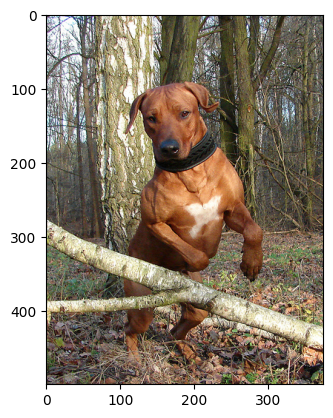

In [85]:
description = generate_desc(model, tokenizer, photo, max_length)
print("\n\n")
print(description)
plt.imshow(img)